In [1]:
import os, pickle, re, glob, time
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from scipy import stats
from collections import Counter

sns.set_style('ticks')
pd.set_option('precision', 2)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

### Read gene expression matrices

In [2]:
mat_norm_df = pd.read_csv('../data/HN_patient_specific/old_norm_cluster_results/mat_norm.csv', index_col=0)
mat_norm_df.head()

,RHH2176,RHH2177,RHH2178,RHH2179,RHH2180,RHH2181,RHH2182,RHH2183,RHH2184,RHH2185,...,RHO708,RHO709,RHO710,RHO711,RHO712,RHO713,RHO714,RHO715,RHO716,RHO717
TSPAN6,0.71,0.67,1.18,1.38,0.33,1.28,0.17,1.10,0.91,0.06,...,1.45,1.34,0.0,1.26,0.52,1.00,1.38,1.41,0.21,0.76
DPM1,0.00,0.13,0.62,0.80,0.62,0.64,0.24,0.38,0.20,0.06,...,1.56,0.24,0.0,0.39,0.25,1.33,1.54,0.97,0.25,0.35
SCYL3,0.00,0.00,0.48,0.19,0.00,0.00,0.00,0.00,0.00,0.00,...,0.24,0.09,0.0,0.35,0.00,0.00,0.00,0.03,0.00,0.09
C1orf112,0.00,0.00,0.00,0.19,0.07,0.00,0.59,0.00,0.00,0.00,...,0.10,0.00,0.0,0.02,0.00,0.04,0.01,0.42,0.07,0.00
FGR,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [3]:
count_df = pd.read_csv('../data/HN_patient_specific/star_rsem_output/HN120-182/countdata.csv', index_col=0)
count_df = count_df.set_index('mat57[, 1]')
count_df.head()

,RHH2176,RHH2177,RHH2178,RHH2179,RHH2180,RHH2181,RHH2182,RHH2183,RHH2184,RHH2185,...,RHO708,RHO709,RHO710,RHO711,RHO712,RHO713,RHO714,RHO715,RHO716,RHO717
"mat57[, 1]",,,,,,,,,,,,,,,,,,,,,
TSPAN6,2.0,7.0,132.0,58.0,11.0,115.0,2.0,13.0,27.0,1.0,...,295.0,116.0,0.0,121.0,38.0,116.0,234.0,227.0,17.0,71.0
TNMD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DPM1,0.0,1.0,50.0,24.0,24.0,40.0,3.0,3.0,4.0,1.0,...,341.0,11.0,0.0,23.0,16.0,189.0,291.0,121.0,20.0,26.0
SCYL3,0.0,0.0,36.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,4.0,0.0,20.0,0.0,0.0,0.0,2.0,0.0,6.0
C1orf112,0.0,0.0,0.0,4.0,2.0,0.0,9.0,0.0,0.0,0.0,...,10.0,0.0,0.0,1.0,0.0,3.0,1.0,38.0,5.0,0.0


In [4]:
count_filtered_df = pd.read_csv('../data/HN_patient_specific/star_rsem_output/HN120-182/filtercount.csv', index_col=0)
count_filtered_df.head()

,RHH2176,RHH2177,RHH2178,RHH2179,RHH2180,RHH2181,RHH2182,RHH2183,RHH2184,RHH2185,...,RHO708,RHO709,RHO710,RHO711,RHO712,RHO713,RHO714,RHO715,RHO716,RHO717
TSPAN6,2.0,7.0,132.0,58.0,11.0,115.0,2.0,13.0,27.0,1.0,...,295.0,116.0,0.0,121.0,38.0,116.0,234.0,227.0,17.0,71.0
DPM1,0.0,1.0,50.0,24.0,24.0,40.0,3.0,3.0,4.0,1.0,...,341.0,11.0,0.0,23.0,16.0,189.0,291.0,121.0,20.0,26.0
SCYL3,0.0,0.0,36.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,4.0,0.0,20.0,0.0,0.0,0.0,2.0,0.0,6.0
C1orf112,0.0,0.0,0.0,4.0,2.0,0.0,9.0,0.0,0.0,0.0,...,10.0,0.0,0.0,1.0,0.0,3.0,1.0,38.0,5.0,0.0
FGR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
tpm_df = pd.read_csv('../data/HN_patient_specific/hn_sc_tpm.csv', index_col=0)
tpm_df.head()

,RHH2177,RHH2178,RHH2179,RHH2180,RHH2181,RHH2182,RHH2184,RHH2185,RHH2186,RHH2187,...,RHO707,RHO708,RHO709,RHO711,RHO712,RHO713,RHO714,RHO715,RHO716,RHO717
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.10,48.85,131.23,178.24,23.44,153.69,9.38,81.05,10.09,145.34,40.21,...,46.83,127.02,121.74,101.40,27.24,72.80,121.54,131.68,18.73,45.72
ENSG00000000419.8,25.66,123.04,159.22,110.39,115.40,51.75,25.92,12.69,231.59,76.11,...,95.78,316.68,24.94,41.63,28.49,247.13,326.69,151.61,27.20,36.17
ENSG00000000457.9,0.00,26.77,4.13,0.00,0.00,0.00,0.00,0.00,0.00,6.94,...,2.41,3.62,1.41,5.64,0.00,0.00,0.00,0.39,0.00,5.66
ENSG00000000460.12,0.00,0.00,29.61,2.47,0.00,24.26,0.00,0.00,0.00,33.15,...,6.01,2.50,0.00,0.49,0.00,0.90,1.67,55.43,7.31,0.00
ENSG00000000971.11,7.30,75.75,0.00,32.28,0.00,4.91,0.00,0.00,0.00,35.99,...,0.00,0.00,0.00,0.00,0.00,0.32,1.62,0.00,0.00,7.88


In [6]:
tmm_df = pd.read_csv('../data/HN_patient_specific/hn_sc_tmm.csv', index_col=0)
tmm_df.head()

,RHH2177,RHH2178,RHH2179,RHH2180,RHH2181,RHH2182,RHH2184,RHH2185,RHH2186,RHH2187,...,RHO707,RHO708,RHO709,RHO711,RHO712,RHO713,RHO714,RHO715,RHO716,RHO717
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.10,54.28,129.62,184.29,24.18,152.12,9.29,88.18,12.62,186.57,47.41,...,30.41,89.90,103.19,76.20,20.28,54.14,80.57,103.73,13.37,33.00
ENSG00000000419.8,28.51,121.53,164.62,113.86,114.22,51.24,28.20,15.88,297.28,89.74,...,62.20,224.14,21.14,31.28,21.21,183.79,216.58,119.42,19.42,26.11
ENSG00000000457.9,0.00,26.44,4.27,0.00,0.00,0.00,0.00,0.00,0.00,8.18,...,1.57,2.56,1.20,4.24,0.00,0.00,0.00,0.31,0.00,4.09
ENSG00000000460.12,0.00,0.00,30.61,2.55,0.00,24.02,0.00,0.00,0.00,39.09,...,3.90,1.77,0.00,0.37,0.00,0.67,1.11,43.66,5.22,0.00
ENSG00000000971.11,8.11,74.82,0.00,33.30,0.00,4.86,0.00,0.00,0.00,42.44,...,0.00,0.00,0.00,0.00,0.00,0.24,1.07,0.00,0.00,5.69


##### gene name mapping file

In [7]:
gene_df = pd.read_csv('../data/HN_patient_specific/gene.csv', index_col=0)[['gene_name']]
gene_id_name_dict = dict(zip(gene_df.index, gene_df['gene_name']))

### Compare expression values

In [69]:
# cell_list = ['RHH2177', 'RHH1618', 'RHO707']
cell_list = ['RHH2177', 'RHH1490', 'RHH2302']

gene_list = set(mat_norm_df.index)
gene_list = gene_list.intersection(count_df.index)
gene_list = gene_list.intersection(count_filtered_df.index)
gene_list = gene_list.intersection([gene_id_name_dict[g] for g in tmm_df.index])
gene_list = sorted(list(gene_list))

len(gene_list)

15087

In [70]:
df_x = mat_norm_df.loc[gene_list, cell_list].reset_index().groupby('index').mean()

x = df_x.values

df_y1 = count_filtered_df.loc[gene_list, cell_list].reset_index().groupby('index').mean()
y1 = df_y1.values

df_y2 = tpm_df.copy()
df_y2.index = [gene_id_name_dict[g] for g in df_y2.index]
df_y2 = df_y2.loc[gene_list, cell_list].reset_index().groupby('index').mean()
y2 = df_y2.values

df_y3 = tmm_df.copy()
df_y3.index = [gene_id_name_dict[g] for g in df_y3.index]
df_y3 = df_y3.loc[gene_list, cell_list].reset_index().groupby('index').mean()
y3 = df_y3.values

In [71]:
x.shape, y1.shape, y2.shape, y3.shape

((15087, 3), (15087, 3), (15087, 3), (15087, 3))

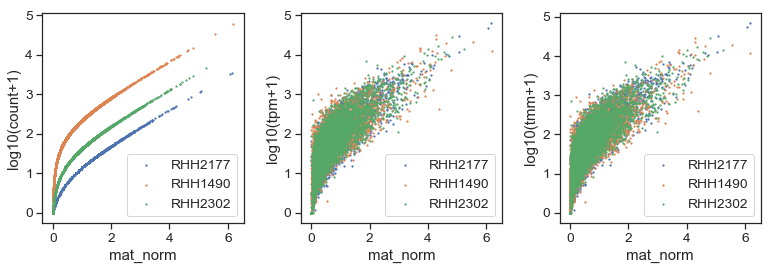

In [72]:
sns.set(style='ticks', font_scale=1.25)
fig, axes = plt.subplots(ncols=3, figsize=(11,4))

for ax, y_label, y in zip(axes.flatten(), ['log10(count+1)', 'log10(tpm+1)', 'log10(tmm+1)'], [y1, y2, y3]):
    for i, cell_id in enumerate(cell_list):
        _ = ax.scatter(x[:, i], np.log10((y[:, i]+1)), s=5, alpha=1, linewidth=0, label=cell_id)
        
    ax.set_ylabel(y_label)
    ax.set_xlabel('mat_norm')
    ax.legend()
    
plt.tight_layout()

##### Transformation

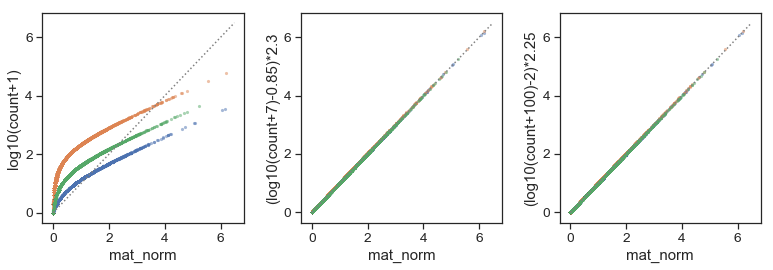

In [73]:
sns.set(style='ticks', font_scale=1.25)
fig, axes = plt.subplots(ncols=3, figsize=(11,4))

for i, cell_id in enumerate(cell_list):
    _ = axes[0].scatter(x[:, i], np.log10(y1[:, i]+1), s=10, alpha=0.5, linewidth=0, label=cell_id)
    axes[0].set_ylabel('log10(count+1)')

#     _ = axes[1].scatter(x[:, i], (np.log10((y1[:, i]+7))-np.log10(7))*2.3, s=10, alpha=0.5, linewidth=0, label=cell_id)
#     axes[1].set_ylabel('(log10(count+7)-0.85)*2.3')
    
#     _ = axes[2].scatter(x[:, i], (np.log10((y1[:, i]+100))-2)*2.25, s=10, alpha=0.5, linewidth=0, label=cell_id)
#     axes[2].set_ylabel('(log10(count+100)-2)*2.25')

    _ = axes[1].scatter(x[:, i], np.log((y1[:, i]+(y1[:, i].sum()/10000))/(y1[:, i].sum()/10000)), s=10, alpha=0.5, linewidth=0, label=cell_id)
    axes[1].set_ylabel('(log10(count+7)-0.85)*2.3')
    
    _ = axes[2].scatter(x[:, i], np.log((y1[:, i]+(y1[:, i].sum()/10000))/(y1[:, i].sum()/10000)), s=10, alpha=0.5, linewidth=0, label=cell_id)
    axes[2].set_ylabel('(log10(count+100)-2)*2.25')

for ax in axes.flatten():
    ax.plot((0, 6.5), (0, 6.5), color='grey', linestyle=':')
    ax.set_xlabel('mat_norm')
#     ax.legend()
    
plt.tight_layout()

##### Check transformation for each cell

In [52]:
cell_list = tmm_df.columns
cell_batch = [c[0:3] for c in cell_list]

In [53]:
df_x = mat_norm_df.loc[gene_list, cell_list].reset_index().groupby('index').mean()
x = df_x.values

df_y = count_filtered_df.loc[gene_list, cell_list].reset_index().groupby('index').mean()
y = df_y.values

In [57]:
from sklearn.metrics import r2_score

t1_err = []
t2_err = []
t3_err = []

for i in range(len(cell_list)):
    y1 = np.log10(y[:, i]+1)
    y2 = (np.log10((y[:, i]+7))-np.log10(7))*2.3
#     y3 = (np.log10((y[:, i]+100))-2)*2.25
    y3= np.log(y[:, i]/(y[:, i].sum()/10000) + 1)
    
    t1_err += [np.mean(np.square(x[:, i] - y1))]
    t2_err += [np.mean(np.square(x[:, i] - y2))]
    t3_err += [np.mean(np.square(x[:, i] - y3))]

#     t1_err += [np.percentile(np.square(x[:, i] - y1), 99)]
#     t2_err += [np.percentile(np.square(x[:, i] - y2), 99)]
#     t3_err += [np.percentile(np.square(x[:, i] - y3), 99)]

#     t1_err += [r2_score(x[:, i], y1) * 100]
#     t2_err += [r2_score(x[:, i], y2) * 100]
#     t3_err += [r2_score(x[:, i], y3) * 100]

In [58]:
err_df = pd.DataFrame(np.array([cell_batch, t1_err, t2_err, t3_err]).T, index=cell_list, columns=['batch', 't1', 't2', 't3'])
err_df.loc[['RHH2177', 'RHH1490', 'RHO707']]

,batch,t1,t2,t3
RHH2177,RHH,0.024806050070389794,0.0002265533289226346,8.933977519935377e-07
RHH1618,RHH,0.6509533416157082,1.47111786271761,4.958468531347103e-07
RHO707,RHO,0.5497989366639466,1.2344206548210839,1.6690909156714238e-06


In [59]:
stacked_err_df = err_df.reset_index().set_index(['index', 'batch']).stack().reset_index()
stacked_err_df.columns = ['cell_id', 'batch', 'transformation', 'mse']
stacked_err_df.loc[:, 'mse'] = stacked_err_df['mse'].astype(float)
stacked_err_df.head()

,cell_id,batch,transformation,mse
0,RHH2177,RHH,t1,2.48e-02
1,RHH2177,RHH,t2,2.27e-04
2,RHH2177,RHH,t3,8.93e-07
3,RHH2178,RHH,t1,3.26e-01
4,RHH2178,RHH,t2,6.82e-01


In [60]:
cell_info_df = pd.read_csv('../data/HN_patient_specific/cellInfo.csv', index_col=0)
stacked_err_df = pd.merge(stacked_err_df, cell_info_df, how='left', left_on='cell_id', right_index=True)

No handles with labels found to put in legend.


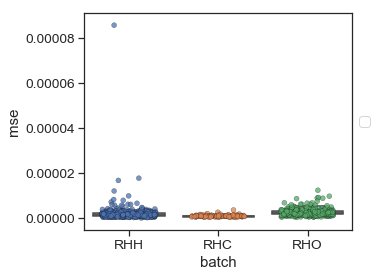

In [61]:
fig, ax = plt.subplots(figsize=(6, 4))

x_label = 'batch'

sns.boxplot(data=stacked_err_df[stacked_err_df['transformation']=='t3'], x=x_label, y='mse', fliersize=0, color='grey', ax=ax)
sns.stripplot(data=stacked_err_df[stacked_err_df['transformation']=='t3'], x=x_label, y='mse', jitter=0.3, dodge=True, alpha=.75, s=5, edgecolor='black', linewidth=0.25, ax=ax)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

[None]

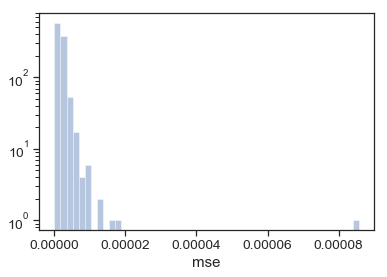

In [66]:
g = sns.distplot(stacked_err_df[stacked_err_df['transformation']=='t3']['mse'], kde=False, norm_hist=False)
g.set(yscale="log")

In [68]:
stacked_err_df[stacked_err_df['transformation']=='t3'].sort_values('mse', ascending=False)

,cell_id,batch,transformation,mse,patient_id,cell_line_id,origin
590,RHH1490,RHH,t3,8.57e-05,HN137,HN137P,Primary
197,RHH2246,RHH,t3,1.77e-05,HN120,HN120P,Primary
47,RHH2193,RHH,t3,1.67e-05,HN120,HN120P,Primary
3074,RHO693,RHO,t3,1.23e-05,HN182,HN182M,Metastasis
335,RHH2298,RHH,t3,1.20e-05,HN120,HN120M,Metastasis
1325,RHH1975,RHH,t3,9.83e-06,HN137,HN137P2,Primary
2684,RHO466,RHO,t3,9.67e-06,HN160,HN160P,Primary
2876,RHO594,RHO,t3,9.11e-06,HN160,HN160M,Metastasis
2636,RHO443,RHO,t3,8.89e-06,HN160,HN160P,Primary
2954,RHO643,RHO,t3,8.78e-06,HN182,HN182M,Metastasis


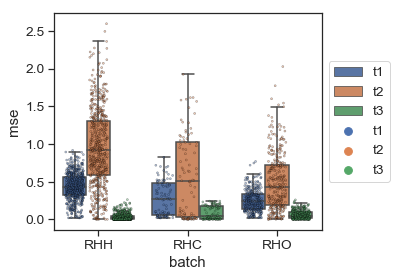

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.boxplot(data=stacked_err_df, x='batch', y='mse', hue='transformation', fliersize=0, ax=ax)
sns.stripplot(data=stacked_err_df, x='batch', y='mse', hue='transformation', jitter=0.3, dodge=True, alpha=0.4, s=2, edgecolor='black', linewidth=0.5, ax=ax)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Compare predictions

Prediction at patient level for selected drugs and drug combinations

##### Single drugs

Read data

In [21]:
mat_norm_pred_df = pd.read_csv('../result/HN_model/old_mat_norm_pred/05_drug_kill_log2_median_ic50_hn_hn_84_drug_cw_dw10_100000_model.csv')[['patient', 'drug_id', 'kill']].pivot(index='drug_id', columns='patient', values='kill')
mat_norm_3f_pred_df = pd.read_csv('../result/HN_model/old_mat_norm_pred/05_drug_kill_log2_median_ic50_3f_hn_hn_84_drug_cw_dw10_100000_model.csv')[['patient', 'drug_id', 'kill']].pivot(index='drug_id', columns='patient', values='kill')

In [22]:
tmm_pred_df = pd.read_csv('../result/HN_model/pred_drug_kill_log2_median_ic50_hn_hn_drug_cw_dw10_100000_model.csv')[['patient', 'drug_id', 'kill']].pivot(index='drug_id', columns='patient', values='kill')
tmm_3f_pred_df = pd.read_csv('../result/HN_model/pred_drug_kill_log2_median_ic50_3f_hn_hn_drug_cw_dw10_100000_model.csv')[['patient', 'drug_id', 'kill']].pivot(index='drug_id', columns='patient', values='kill')

In [23]:
mat_norm_pred_df.head()

patient,HN120,HN137,HN148,HN159,HN160,HN182
drug_id,,,,,,
133,66.61,64.02,42.92,42.59,34.56,8.39
134,62.57,62.63,35.42,43.68,42.99,8.18
182,54.15,57.17,32.02,32.86,19.41,8.48
190,74.49,83.74,47.88,57.12,52.72,12.39
194,48.14,51.28,29.49,31.96,29.19,8.65


In [24]:
tmm_pred_df.head()

patient,HN120,HN137,HN148,HN159,HN160,HN182
drug_id,,,,,,
133,73.93,53.52,35.71,48.53,14.89,6.13
134,68.73,52.42,28.80,50.55,19.33,5.46
135,84.89,57.87,34.35,40.58,5.02,1.20
136,74.96,66.32,50.76,53.67,23.71,16.91
140,45.62,31.15,12.12,35.81,9.21,5.36


Combine and compare

In [25]:
patient_list = sorted(tmm_pred_df.columns)
patient_list

['HN120', 'HN137', 'HN148', 'HN159', 'HN160', 'HN182']

In [26]:
common_drug_list = set(mat_norm_pred_df.index).intersection(tmm_pred_df.index)
len(common_drug_list)

31

In [27]:
selected_drug_id_list = [1032, 1007, 133, 201, 1010, 182, 301, 302, 1012]
selected_drug_list = ['Afatinib', 'Docetaxel', 'Doxorubicin', 'Epothilone B', 'Gefitinib', 'Obatoclax Mesylate', 'PHA-793887', 'PI-103', 'Vorinostat']
drug_id_name_dict = dict(zip(selected_drug_id_list, selected_drug_list))

In [28]:
x = mat_norm_pred_df.loc[selected_drug_id_list, patient_list].values
y = tmm_pred_df.loc[selected_drug_id_list, patient_list].values

In [29]:
x_df = mat_norm_pred_df.loc[selected_drug_id_list, patient_list].stack().reset_index()
x_df.columns = ['drug_id', 'patient', 'mat_norm']

y_df = tmm_pred_df.loc[selected_drug_id_list, patient_list].stack().reset_index()
y_df.columns = ['drug_id', 'patient', 'TMM']

xy_df = pd.merge(x_df, y_df, left_on=['drug_id', 'patient'], right_on=['drug_id', 'patient'])

xy_df.loc[:, 'drug_name'] = [drug_id_name_dict[d] for d in xy_df['drug_id']]

xy_df.head()

,drug_id,patient,mat_norm,TMM,drug_name
0,1032,HN120,15.67,10.15,Afatinib
1,1032,HN137,14.50,9.22,Afatinib
2,1032,HN148,20.65,15.96,Afatinib
3,1032,HN159,4.65,7.62,Afatinib
4,1032,HN160,5.19,10.25,Afatinib


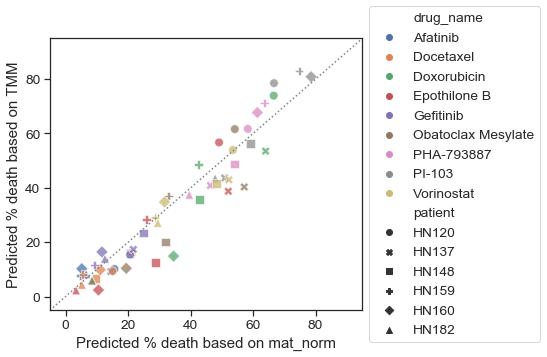

In [30]:
sns.set(font_scale=1.25, style='ticks')
fig, ax = plt.subplots(figsize=(7,5))

# for i, d in enumerate(selected_drug_list):
#     ax.scatter(x[i, :], y[i, :], label=d, alpha=0.6)
#     break
sns.scatterplot(data=xy_df, x='mat_norm', y='TMM', hue='drug_name', style='patient', s=75, alpha=0.75)

vmin = -5
vmax = 95
ax.plot((vmin, vmax), (vmin, vmax), color='grey', linestyle=':')
ax.set_xlim((vmin, vmax))
ax.set_ylim((vmin, vmax))

ax.set_xlabel('Predicted % death based on mat_norm')
ax.set_ylabel('Predicted % death based on TMM')
ax.legend()

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

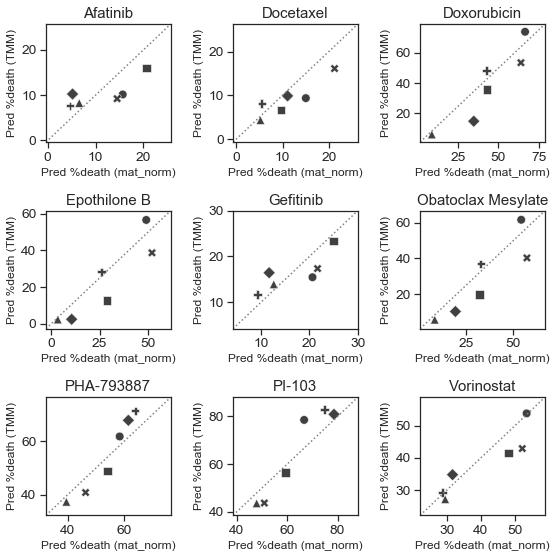

In [31]:
sns.set(font_scale=1.25, style='ticks')
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
axes = axes.flatten()

for i, d in enumerate(selected_drug_list):
    
    vmin = np.concatenate([x[i, :], y[i, :]]).min() - 5
    vmax = np.concatenate([x[i, :], y[i, :]]).max() + 5
    
#     for xval, yval in zip(x[i, :], y[i, :]):
#         axes[i].scatter(xval, yval, label=d, s=50, alpha=0.6)
    sns.scatterplot(data=xy_df[xy_df['drug_name']==d], x='mat_norm', y='TMM', style='patient', s=75, alpha=0.75, color='black', ax=axes[i])
        
    axes[i].set_title(d)
    axes[i].plot((vmin, vmax), (vmin, vmax), color='grey', linestyle=':')
    axes[i].set_xlim((vmin, vmax))
    axes[i].set_ylim((vmin, vmax))
    axes[i].legend().remove()
    axes[i].set_xlabel('Pred %death (mat_norm)', fontsize=12)
    axes[i].set_ylabel('Pred %death (TMM)', fontsize=12)

plt.tight_layout()

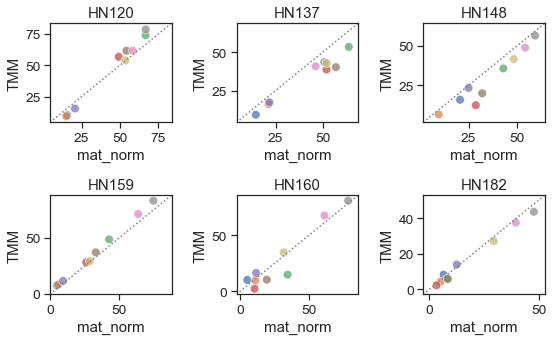

In [32]:
sns.set(font_scale=1.25, style='ticks')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 5))
axes = axes.flatten()

for i, p in enumerate(patient_list):

    vmin = np.concatenate([x[:, i], y[:, i]]).min() - 5
    vmax = np.concatenate([x[:, i], y[:, i]]).max() + 5
    
#     for xval, yval in zip(x[:, i], y[:, i]):
#         axes[i].scatter(xval, yval, label=p, s=50, alpha=0.6)
    sns.scatterplot(data=xy_df[xy_df['patient']==p], x='mat_norm', y='TMM', hue='drug_name', s=75, alpha=0.75, color='black', ax=axes[i])

    axes[i].set_title(p)
    axes[i].plot((vmin, vmax), (vmin, vmax), color='grey', linestyle=':')
    axes[i].set_xlim((vmin, vmax))
    axes[i].set_ylim((vmin, vmax))
    axes[i].legend().remove()
    
plt.tight_layout()